## Hyperspectral Image Segmentation by Convolutional Neural Network 

### Binned spectra (424, 283, 212, 170, 142, 122, 106, 85, 53, 22, 15)
### with spatial dimension included

### training on each image separately

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

In [8]:
def read_labelled_coordinates(kind, scan):
    file = open("../manual_classified_pixels/{0}_coordinates_{1}.txt".format(kind, scan), "r")
    coords = file.readlines()
    file.close()
    coords = np.array([point_from_string(line) for line in coords])
    print("{0}: {1}".format(kind,coords.shape))
    
    return coords

In [9]:
import random

def split_train_test_indices(coords, seed, trrat, kind):
    ind = np.arange(coords.shape[0])
    random.Random(seed).shuffle(ind)
    lim_ind = int(len(ind)*trrat)
    train_ind = ind[:lim_ind]
    test_ind = ind[lim_ind:]
    
    print("{0}: {1} {2}".format(kind, len(train_ind), len(test_ind)))
    
    return train_ind, test_ind

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def CNN_Model(nwaves):
    Inputs_1 = keras.Input(shape=(nwaves, 1), name="spectra")
    Conv1D_1 = layers.Conv1D(16, kernel_size=(50), padding="same", activation="relu")(Inputs_1)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    Dropout_1 = layers.Dropout(0.5)(MaxPool_2)
    Flatten_1 = layers.Flatten()(Dropout_1)

    Inputs_2 = keras.Input(shape=(2,), name="spatial")
    Concat = layers.concatenate([Flatten_1, Inputs_2])
    Dense_1 = layers.Dense(512, activation="relu")(Concat)
    Output = layers.Dense(9, activation="softmax")(Dense_1)

    model = keras.Model(inputs=[Inputs_1, Inputs_2],
                        outputs=[Output],)
    
    return model

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_history(model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'], loc='center right')
    ax2.plot(model.history['accuracy'])
    ax2.plot(model.history['val_accuracy'])
    ax2.set_title('CNN Model Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=12, axis='x')
    ax2.legend(['train', 'test'], loc='center right')
    ax3.plot(model.history['loss'])
    ax3.plot(model.history['val_loss'])
    ax3.set_ylabel('log(loss)')
    ax3.set_xlabel('epoch')
    ax3.locator_params(nbins=13, axis='x')
    ax3.legend(['train', 'test'], loc='center right')
    ax3.set_yscale('log')
    ax4.plot(model.history['accuracy'])
    ax4.plot(model.history['val_accuracy'])
    ax4.set_ylabel('log(accuracy)')
    ax4.set_xlabel('epoch')
    ax4.locator_params(nbins=12, axis='x')
    ax4.legend(['train', 'test'], loc='center right')
    ax4.set_yscale('log')
    plt.show()

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN on veg_00108 (South Facing @ ~2pm)

In [12]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [13]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [14]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [15]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
print(cube_standard.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [16]:
sky_coords = read_labelled_coordinates("1_sky", "108")
clouds_coords = read_labelled_coordinates("2_clouds", "108")
veg_coords = read_labelled_coordinates("3_vegetation", "108")
wtr_coords = read_labelled_coordinates("4_water", "108")
blt_coords = read_labelled_coordinates("5_buildings", "108")
windows_coords = read_labelled_coordinates("6_windows", "108")
rds_coords = read_labelled_coordinates("7_roads", "108")
cars_coords = read_labelled_coordinates("8_cars", "108")
mtl_coords = read_labelled_coordinates("9_metal", "108")

1_sky: (300, 2)
2_clouds: (500, 2)
3_vegetation: (600, 2)
4_water: (50, 2)
5_buildings: (1020, 2)
6_windows: (500, 2)
7_roads: (30, 2)
8_cars: (100, 2)
9_metal: (100, 2)


In [17]:
# create position array and normalize

xy = coords(cube_sub.shape[1], cube_sub.shape[2])
xy = xy/xy.max()

### Bin Spectra

In [18]:
num_of_bins = 424
bin_ind = []

for i in range(0, num_of_bins):
    low_ind = int(i*int(cube_sub.shape[0]/num_of_bins))
    upp_ind = int(low_ind + int(cube_sub.shape[0]/num_of_bins))
    bin_ind.append([low_ind, upp_ind])
bin_ind[-1][-1] = cube_sub.shape[0]

print(len(bin_ind))
print(bin_ind)

424
[[0, 2], [2, 4], [4, 6], [6, 8], [8, 10], [10, 12], [12, 14], [14, 16], [16, 18], [18, 20], [20, 22], [22, 24], [24, 26], [26, 28], [28, 30], [30, 32], [32, 34], [34, 36], [36, 38], [38, 40], [40, 42], [42, 44], [44, 46], [46, 48], [48, 50], [50, 52], [52, 54], [54, 56], [56, 58], [58, 60], [60, 62], [62, 64], [64, 66], [66, 68], [68, 70], [70, 72], [72, 74], [74, 76], [76, 78], [78, 80], [80, 82], [82, 84], [84, 86], [86, 88], [88, 90], [90, 92], [92, 94], [94, 96], [96, 98], [98, 100], [100, 102], [102, 104], [104, 106], [106, 108], [108, 110], [110, 112], [112, 114], [114, 116], [116, 118], [118, 120], [120, 122], [122, 124], [124, 126], [126, 128], [128, 130], [130, 132], [132, 134], [134, 136], [136, 138], [138, 140], [140, 142], [142, 144], [144, 146], [146, 148], [148, 150], [150, 152], [152, 154], [154, 156], [156, 158], [158, 160], [160, 162], [162, 164], [164, 166], [166, 168], [168, 170], [170, 172], [172, 174], [174, 176], [176, 178], [178, 180], [180, 182], [182, 184],

In [19]:
cube_binned = np.zeros(shape=(cube_standard.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binned[:, i] = cube_standard[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binned.shape)

(2560000, 424)


In [20]:
cube_standard = cube_binned
print(cube_standard.shape)

(2560000, 424)


#### split classified pixels into 80% training and 20% testing sets

In [21]:
trrat = 0.8
sky_train_ind, sky_test_ind = split_train_test_indices(sky_coords, 0, trrat, "sky")
clouds_train_ind, clouds_test_ind = split_train_test_indices(clouds_coords, 1, trrat, "clouds")
veg_train_ind, veg_test_ind = split_train_test_indices(veg_coords, 2, trrat, "veg")
wtr_train_ind, wtr_test_ind = split_train_test_indices(wtr_coords, 3, trrat, "wtr")
blt_train_ind, blt_test_ind = split_train_test_indices(blt_coords, 4, trrat, "blt")
windows_train_ind, windows_test_ind = split_train_test_indices(windows_coords, 5, trrat, "windows")
rds_train_ind, rds_test_ind = split_train_test_indices(rds_coords, 6, trrat, "rds")
cars_train_ind, cars_test_ind = split_train_test_indices(cars_coords, 7, trrat, "cars")
mtl_train_ind, mtl_test_ind = split_train_test_indices(mtl_coords, 8, trrat, "mtl")

sky: 240 60
clouds: 400 100
veg: 480 120
wtr: 40 10
blt: 816 204
windows: 400 100
rds: 24 6
cars: 80 20
mtl: 80 20


In [22]:
cube_std_3d = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], num_of_bins)
print(cube_std_3d.shape)
print(xy.shape)

(1600, 1600, 424)
(1600, 1600, 2)


In [23]:
cube_sky_train = cube_std_3d[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_std_3d[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
sky_xy_train = xy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
sky_xy_test = xy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_std_3d[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_std_3d[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
clouds_xy_train = xy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
clouds_xy_test = xy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_std_3d[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_std_3d[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
veg_xy_train = xy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
veg_xy_test = xy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_std_3d[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_std_3d[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
wtr_xy_train = xy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
wtr_xy_test = xy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_std_3d[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_std_3d[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
blt_xy_train = xy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
blt_xy_test = xy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_std_3d[windows_coords[windows_train_ind[:],0], windows_coords[windows_train_ind[:],1],:]
cube_windows_test = cube_std_3d[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
windows_xy_train = xy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
windows_xy_test = xy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_std_3d[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_std_3d[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
rds_xy_train = xy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
rds_xy_test = xy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_std_3d[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_std_3d[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
cars_xy_train = xy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cars_xy_test = xy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_std_3d[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_std_3d[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
mtl_xy_train = xy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
mtl_xy_test = xy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 424) (60, 424)
clouds  (400, 424) (100, 424)
vegetation  (480, 424) (120, 424)
water  (40, 424) (10, 424)
built  (816, 424) (204, 424)
windows  (400, 424) (100, 424)
roads  (24, 424) (6, 424)
cars  (80, 424) (20, 424)
metal  (80, 424) (20, 424)


In [24]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]
xy_train = np.concatenate((sky_xy_train, clouds_xy_train, veg_xy_train, wtr_xy_train, blt_xy_train,
                             windows_xy_train, rds_xy_train, cars_xy_train, mtl_xy_train), axis=0)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]
xy_test = np.concatenate((sky_xy_test, clouds_xy_test, veg_xy_test, wtr_xy_test, blt_xy_test,
                             windows_xy_test, rds_xy_test, cars_xy_test, mtl_xy_test), axis=0)

In [25]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

print(cube_train.shape, cube_train_labels.shape, xy_train.shape)
print(cube_test.shape, cube_test_labels.shape, xy_test.shape)

(2560, 424) (2560,) (2560, 2)
(640, 424) (640,) (640, 2)


### Train CNN

In [26]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [27]:
#keras.utils.plot_model(cnn, show_shapes=True)
#cnn.summary()

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

In [28]:
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=200, batch_size=512)

Epoch 1/200
5/5 [==============================] - 1s 154ms/step - loss: 1.6394 - accuracy: 0.4523 - val_loss: 1.0375 - val_accuracy: 0.6516
Epoch 2/200
5/5 [==============================] - 0s 88ms/step - loss: 0.9479 - accuracy: 0.7023 - val_loss: 0.7780 - val_accuracy: 0.7406
Epoch 3/200
5/5 [==============================] - 0s 86ms/step - loss: 0.7706 - accuracy: 0.7422 - val_loss: 0.7065 - val_accuracy: 0.8016
Epoch 4/200
5/5 [==============================] - 0s 88ms/step - loss: 0.6887 - accuracy: 0.7789 - val_loss: 0.5845 - val_accuracy: 0.8156
Epoch 5/200
5/5 [==============================] - 0s 84ms/step - loss: 0.6212 - accuracy: 0.8035 - val_loss: 0.5228 - val_accuracy: 0.8500
Epoch 6/200
5/5 [==============================] - 0s 91ms/step - loss: 0.5290 - accuracy: 0.8375 - val_loss: 0.4529 - val_accuracy: 0.8422
Epoch 7/200
5/5 [==============================] - 0s 90ms/step - loss: 0.4711 - accuracy: 0.8562 - val_loss: 0.4017 - val_accuracy: 0.8797
Epoch 8/200
5/5 [==

5/5 [==============================] - 0s 88ms/step - loss: 0.1930 - accuracy: 0.9332 - val_loss: 0.1702 - val_accuracy: 0.9531
Epoch 60/200
5/5 [==============================] - 1s 100ms/step - loss: 0.1709 - accuracy: 0.9438 - val_loss: 0.1616 - val_accuracy: 0.9453
Epoch 61/200
5/5 [==============================] - 0s 87ms/step - loss: 0.1800 - accuracy: 0.9414 - val_loss: 0.1475 - val_accuracy: 0.9469
Epoch 62/200
5/5 [==============================] - 0s 84ms/step - loss: 0.1728 - accuracy: 0.9391 - val_loss: 0.1638 - val_accuracy: 0.9328
Epoch 63/200
5/5 [==============================] - 0s 90ms/step - loss: 0.1840 - accuracy: 0.9379 - val_loss: 0.1513 - val_accuracy: 0.9516
Epoch 64/200
5/5 [==============================] - 0s 96ms/step - loss: 0.1626 - accuracy: 0.9438 - val_loss: 0.1566 - val_accuracy: 0.9406
Epoch 65/200
5/5 [==============================] - 0s 98ms/step - loss: 0.1586 - accuracy: 0.9480 - val_loss: 0.1344 - val_accuracy: 0.9422
Epoch 66/200
5/5 [=======

Epoch 117/200
5/5 [==============================] - 0s 84ms/step - loss: 0.0826 - accuracy: 0.9727 - val_loss: 0.0930 - val_accuracy: 0.9672
Epoch 118/200
5/5 [==============================] - 0s 93ms/step - loss: 0.0870 - accuracy: 0.9754 - val_loss: 0.0907 - val_accuracy: 0.9688
Epoch 119/200
5/5 [==============================] - 0s 99ms/step - loss: 0.1197 - accuracy: 0.9582 - val_loss: 0.3744 - val_accuracy: 0.8500
Epoch 120/200
5/5 [==============================] - 0s 98ms/step - loss: 0.4141 - accuracy: 0.8699 - val_loss: 0.1564 - val_accuracy: 0.9391
Epoch 121/200
5/5 [==============================] - 1s 107ms/step - loss: 0.2231 - accuracy: 0.9223 - val_loss: 0.1957 - val_accuracy: 0.9344
Epoch 122/200
5/5 [==============================] - 0s 96ms/step - loss: 0.2179 - accuracy: 0.9266 - val_loss: 0.1581 - val_accuracy: 0.9359
Epoch 123/200
5/5 [==============================] - 0s 88ms/step - loss: 0.1862 - accuracy: 0.9367 - val_loss: 0.1624 - val_accuracy: 0.9406
Epoch

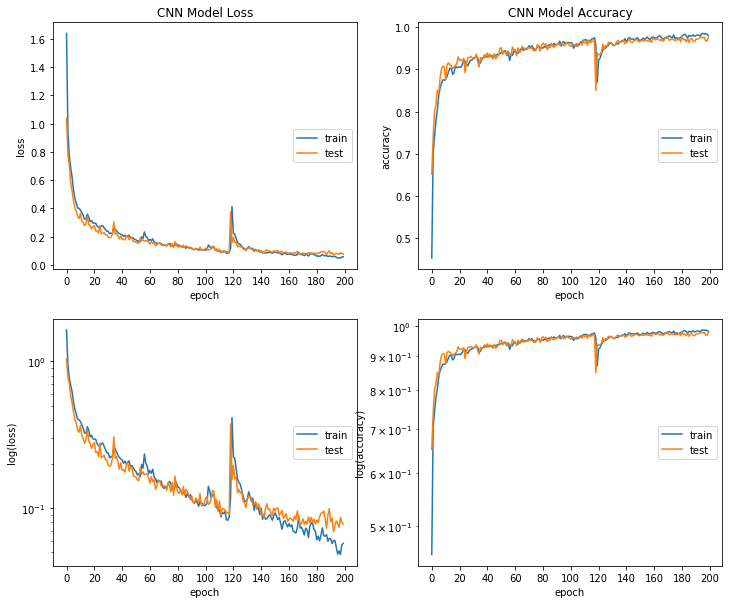

In [29]:
plot_loss_history(CNNmodel)

In [30]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=140, batch_size=512)

Epoch 1/140
5/5 [==============================] - 1s 134ms/step - loss: 1.7352 - accuracy: 0.3590 - val_loss: 1.2521 - val_accuracy: 0.6250
Epoch 2/140
5/5 [==============================] - 0s 87ms/step - loss: 1.0708 - accuracy: 0.6730 - val_loss: 0.8430 - val_accuracy: 0.7141
Epoch 3/140
5/5 [==============================] - 0s 93ms/step - loss: 0.8281 - accuracy: 0.7324 - val_loss: 0.7202 - val_accuracy: 0.7547
Epoch 4/140
5/5 [==============================] - 0s 95ms/step - loss: 0.7399 - accuracy: 0.7723 - val_loss: 0.6347 - val_accuracy: 0.8250
Epoch 5/140
5/5 [==============================] - 1s 105ms/step - loss: 0.6519 - accuracy: 0.7852 - val_loss: 0.5832 - val_accuracy: 0.8281
Epoch 6/140
5/5 [==============================] - 1s 102ms/step - loss: 0.5943 - accuracy: 0.8102 - val_loss: 0.5242 - val_accuracy: 0.8188
Epoch 7/140
5/5 [==============================] - 0s 92ms/step - loss: 0.5536 - accuracy: 0.8223 - val_loss: 0.5017 - val_accuracy: 0.8234
Epoch 8/140
5/5 [

5/5 [==============================] - 0s 89ms/step - loss: 0.1744 - accuracy: 0.9387 - val_loss: 0.1500 - val_accuracy: 0.9500
Epoch 60/140
5/5 [==============================] - 0s 86ms/step - loss: 0.1632 - accuracy: 0.9441 - val_loss: 0.1494 - val_accuracy: 0.9391
Epoch 61/140
5/5 [==============================] - 0s 98ms/step - loss: 0.1625 - accuracy: 0.9438 - val_loss: 0.1603 - val_accuracy: 0.9438
Epoch 62/140
5/5 [==============================] - 0s 94ms/step - loss: 0.1735 - accuracy: 0.9410 - val_loss: 0.1657 - val_accuracy: 0.9531
Epoch 63/140
5/5 [==============================] - 0s 93ms/step - loss: 0.1695 - accuracy: 0.9398 - val_loss: 0.1479 - val_accuracy: 0.9484
Epoch 64/140
5/5 [==============================] - 1s 111ms/step - loss: 0.1621 - accuracy: 0.9465 - val_loss: 0.1408 - val_accuracy: 0.9500
Epoch 65/140
5/5 [==============================] - 0s 88ms/step - loss: 0.1577 - accuracy: 0.9465 - val_loss: 0.1501 - val_accuracy: 0.9406
Epoch 66/140
5/5 [=======

Epoch 117/140
5/5 [==============================] - 1s 104ms/step - loss: 0.0927 - accuracy: 0.9684 - val_loss: 0.1052 - val_accuracy: 0.9594
Epoch 118/140
5/5 [==============================] - 1s 102ms/step - loss: 0.0821 - accuracy: 0.9742 - val_loss: 0.0959 - val_accuracy: 0.9672
Epoch 119/140
5/5 [==============================] - 0s 93ms/step - loss: 0.0820 - accuracy: 0.9727 - val_loss: 0.1007 - val_accuracy: 0.9641
Epoch 120/140
5/5 [==============================] - 1s 104ms/step - loss: 0.0855 - accuracy: 0.9680 - val_loss: 0.0922 - val_accuracy: 0.9688
Epoch 121/140
5/5 [==============================] - 0s 91ms/step - loss: 0.0751 - accuracy: 0.9762 - val_loss: 0.0907 - val_accuracy: 0.9656
Epoch 122/140
5/5 [==============================] - 0s 89ms/step - loss: 0.0856 - accuracy: 0.9668 - val_loss: 0.0984 - val_accuracy: 0.9688
Epoch 123/140
5/5 [==============================] - 0s 91ms/step - loss: 0.0856 - accuracy: 0.9715 - val_loss: 0.0945 - val_accuracy: 0.9656
Epo

In [31]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn.evaluate({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels)
test_loss, test_acc = cnn.evaluate({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels)

print(train_acc, test_acc)

20/20 [==============================] - 0s 6ms/step - loss: 0.0991 - accuracy: 0.9641
0.975781261920929 0.964062511920929


### Predict pixel classification on veg_00108

In [32]:
cube_standard_1 = cube_standard.reshape(cube_standard.shape[0], cube_standard.shape[1], 1)
print(cube_standard_1.shape)
xy_2d = xy.reshape((xy.shape[0] * xy.shape[1]), xy.shape[2])
print(xy_2d.shape)

(2560000, 424, 1)
(2560000, 2)


In [33]:
# classify entire binned cube
import time
start_time = time.time()

probCube = cnn.predict({"spectra":cube_standard_1, "spatial":xy_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:07:53


In [34]:
predictCube = probCube.argmax(axis=-1)

In [35]:
predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

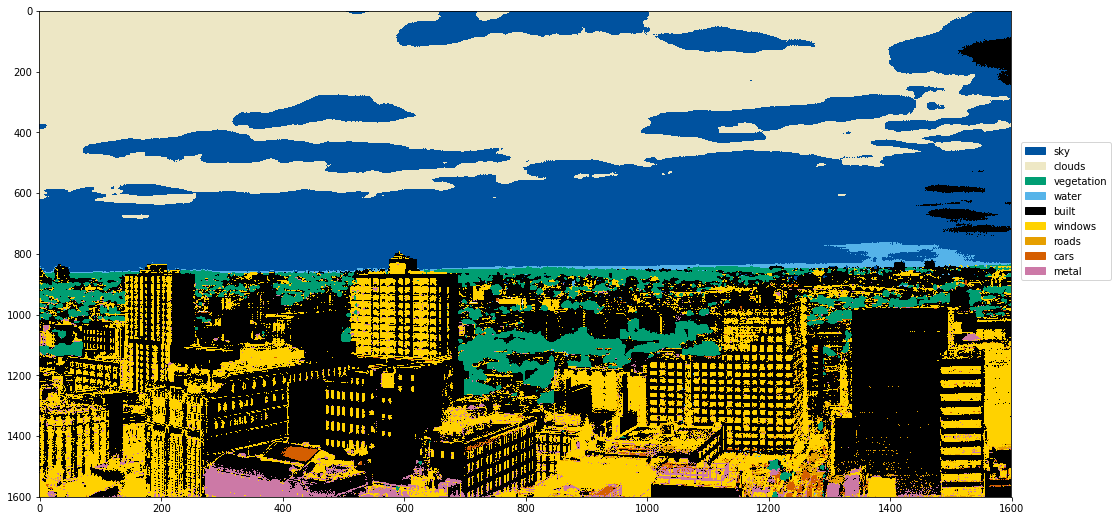

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_1_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

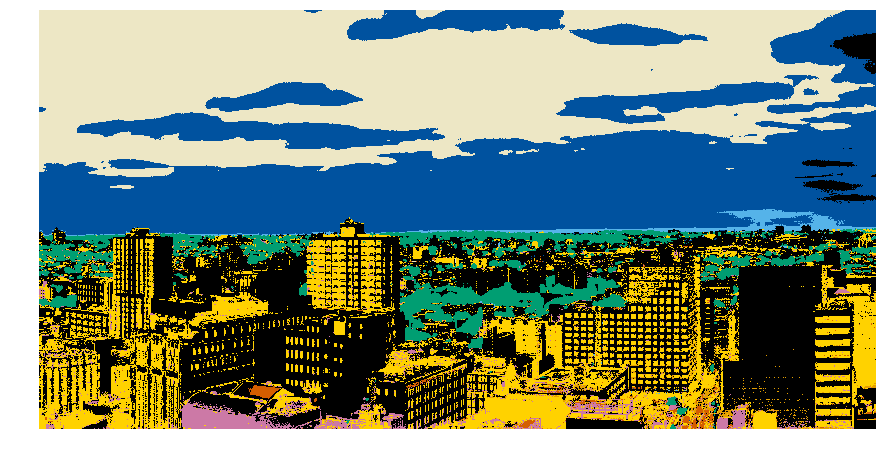

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_108_binned_{0}_test_108_predict_map.png".format(num_of_bins), 
            bbox_inches='tight')

In [44]:
import pickle
pickle.dump(predictCube_reshape,
            open("./plots/CNN_Model2_spatial_train_108_binned_{0}_test_108_predict_map.pickle".format(num_of_bins), 
                 "wb"))

### Evaluation Metrics (veg_00108)

In [45]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [46]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [47]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [48]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 120   0   0   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 196   5   0   1   2]
 [  0   0   0   0   0 100   0   0   0]
 [  0   0   0   0   0   0   6   0   0]
 [  0   0   0   0   2   4   0  13   1]
 [  0   0   0   0   4   4   0   0  12]]

Accuracy Score
0.9640625

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      1.00      1.00       120
      water       1.00      1.00      1.00        10
      built       0.97      0.96      0.97       204
    windows       0.88      1.00      0.94       100
      roads       1.00      1.00      1.00         6
       cars       0.93      0.65      0.76        20
      metal       0.80      0.60      0.69        20

avg / total       0.96      0.96      0.96       6

In [49]:
f = open("./metrics/CNN_Model2_spatial_train_108_binned_{0}_test_108_metrics.txt".format(num_of_bins), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

---
## CNN trained on veg_00000 (Scene 1-b South Facing @ ~6pm)

In [50]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../../image_files/veg_00000.hdr...
reading ../../image_files/veg_00000.raw...


In [51]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [52]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


In [53]:
cube_standard0 = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)
print(cube_standard0.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [54]:
sky_coords0 = read_labelled_coordinates("1_sky", "000")
clouds_coords0 = read_labelled_coordinates("2_clouds", "000")
veg_coords0 = read_labelled_coordinates("3_vegetation", "000")
wtr_coords0 = read_labelled_coordinates("4_water", "000")
blt_coords0 = read_labelled_coordinates("5_buildings", "000")
windows_coords0 = read_labelled_coordinates("6_windows", "000")
rds_coords0 = read_labelled_coordinates("7_roads", "000")
cars_coords0 = read_labelled_coordinates("8_cars", "000")
mtl_coords0 = read_labelled_coordinates("9_metal", "000")

1_sky: (400, 2)
2_clouds: (500, 2)
3_vegetation: (610, 2)
4_water: (0,)
5_buildings: (1200, 2)
6_windows: (500, 2)
7_roads: (60, 2)
8_cars: (55, 2)
9_metal: (230, 2)


In [55]:
# create position array and normalize

xy0 = coords(cube_sub0.shape[1], cube_sub0.shape[2])
xy0 = xy0/xy0.max()

### Bin Spectra

In [56]:
cube_binned0 = np.zeros(shape=(cube_standard0.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binned0[:, i] = cube_standard0[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binned0.shape)

(2560000, 424)


In [57]:
cube_standard0 = cube_binned0
print(cube_standard0.shape)

(2560000, 424)


#### split classified pixels into 80% training and 20% testing sets

In [58]:
trrat = 0.8
sky_train_ind0, sky_test_ind0 = split_train_test_indices(sky_coords0, 10, trrat, "sky")
clouds_train_ind0, clouds_test_ind0 = split_train_test_indices(clouds_coords0, 20, trrat, "clouds")
veg_train_ind0, veg_test_ind0 = split_train_test_indices(veg_coords0, 30, trrat, "veg")
#wtr_train_ind0, wtr_test_ind0 = split_train_test_indices(wtr_coords0, 40, trrat, "wtr")
blt_train_ind0, blt_test_ind0 = split_train_test_indices(blt_coords0, 50, trrat, "blt")
windows_train_ind0, windows_test_ind0 = split_train_test_indices(windows_coords0, 60, trrat, "windows")
rds_train_ind0, rds_test_ind0 = split_train_test_indices(rds_coords0, 70, trrat, "rds")
cars_train_ind0, cars_test_ind0 = split_train_test_indices(cars_coords0, 80, trrat, "cars")
mtl_train_ind0, mtl_test_ind0 = split_train_test_indices(mtl_coords0, 90, trrat, "mtl")

sky: 320 80
clouds: 400 100
veg: 488 122
blt: 960 240
windows: 400 100
rds: 48 12
cars: 44 11
mtl: 184 46


In [59]:
cube_std0_3d = cube_standard0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], num_of_bins)
print(cube_std0_3d.shape)
print(xy0.shape)

(1600, 1600, 424)
(1600, 1600, 2)


In [60]:
cube_sky_train0 = cube_std0_3d[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
cube_sky_test0 = cube_std0_3d[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
sky_xy_train0 = xy0[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
sky_xy_test0 = xy0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
print("sky ", cube_sky_train0.shape, cube_sky_test0.shape)


cube_clouds_train0 = cube_std0_3d[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
cube_clouds_test0 = cube_std0_3d[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
clouds_xy_train0 = xy0[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
clouds_xy_test0 = xy0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
print("clouds ", cube_clouds_train0.shape, cube_clouds_test0.shape)

cube_veg_train0 = cube_std0_3d[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
cube_veg_test0 = cube_std0_3d[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
veg_xy_train0 = xy0[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
veg_xy_test0 = xy0[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
print("vegetation ", cube_veg_train0.shape, cube_veg_test0.shape)

#cube_wtr_train0 = cube_std0_3d[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#cube_wtr_test0 = cube_std0_3d[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#wtr_xy_train0 = xy0[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#wtr_xy_test0 = xy0[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#print("water ", cube_wtr_train0.shape, cube_wtr_test0.shape)

cube_blt_train0 = cube_std0_3d[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
cube_blt_test0 = cube_std0_3d[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
blt_xy_train0 = xy0[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
blt_xy_test0 = xy0[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
print("built ", cube_blt_train0.shape, cube_blt_test0.shape)

cube_windows_train0 = cube_std0_3d[windows_coords0[windows_train_ind0[:],0], windows_coords0[windows_train_ind0[:],1],:]
cube_windows_test0 = cube_std0_3d[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
windows_xy_train0 = xy0[windows_coords0[windows_train_ind0[:], 0], windows_coords0[windows_train_ind0[:], 1], :]
windows_xy_test0 = xy0[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
print("windows ", cube_windows_train0.shape, cube_windows_test0.shape)

cube_rds_train0 = cube_std0_3d[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
cube_rds_test0 = cube_std0_3d[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
rds_xy_train0 = xy0[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
rds_xy_test0 = xy0[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
print("roads ", cube_rds_train0.shape, cube_rds_test0.shape)

cube_cars_train0 = cube_std0_3d[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cube_cars_test0 = cube_std0_3d[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
cars_xy_train0 = xy0[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cars_xy_test0 = xy0[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
print("cars ", cube_cars_train0.shape, cube_cars_test0.shape)

cube_mtl_train0 = cube_std0_3d[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
cube_mtl_test0 = cube_std0_3d[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
mtl_xy_train0 = xy0[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
mtl_xy_test0 = xy0[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
print("metal ", cube_mtl_train0.shape, cube_mtl_test0.shape)

sky  (320, 424) (80, 424)
clouds  (400, 424) (100, 424)
vegetation  (488, 424) (122, 424)
built  (960, 424) (240, 424)
windows  (400, 424) (100, 424)
roads  (48, 424) (12, 424)
cars  (44, 424) (11, 424)
metal  (184, 424) (46, 424)


In [61]:
cube_train0 = np.concatenate((cube_sky_train0, cube_clouds_train0, cube_veg_train0, cube_blt_train0,
                             cube_windows_train0, cube_rds_train0, cube_cars_train0, cube_mtl_train0), axis=0)
cube_train_labels0 = [0]*cube_sky_train0.shape[0] + [1]*cube_clouds_train0.shape[0] \
                + [2]*cube_veg_train0.shape[0] + [4]*cube_blt_train0.shape[0] \
                + [5]*cube_windows_train0.shape[0] + [6]*cube_rds_train0.shape[0] \
                + [7]*cube_cars_train0.shape[0] + [8]*cube_mtl_train0.shape[0]
xy_train0 = np.concatenate((sky_xy_train0, clouds_xy_train0, veg_xy_train0, blt_xy_train0,
                             windows_xy_train0, rds_xy_train0, cars_xy_train0, mtl_xy_train0), axis=0)

cube_test0 = np.concatenate((cube_sky_test0, cube_clouds_test0, cube_veg_test0, cube_blt_test0,
                             cube_windows_test0, cube_rds_test0, cube_cars_test0, cube_mtl_test0), axis=0)
cube_test_labels0 = [0]*cube_sky_test0.shape[0] + [1]*cube_clouds_test0.shape[0] \
                + [2]*cube_veg_test0.shape[0] + [4]*cube_blt_test0.shape[0] \
                + [5]*cube_windows_test0.shape[0] + [6]*cube_rds_test0.shape[0] \
                + [7]*cube_cars_test0.shape[0] + [8]*cube_mtl_test0.shape[0]
xy_test0 = np.concatenate((sky_xy_test0, clouds_xy_test0, veg_xy_test0, blt_xy_test0,
                             windows_xy_test0, rds_xy_test0, cars_xy_test0, mtl_xy_test0), axis=0)

In [62]:
cube_train_labels0 = np.array(cube_train_labels0)
cube_test_labels0 = np.array(cube_test_labels0)

print(cube_train0.shape, cube_train_labels0.shape, xy_train0.shape)
print(cube_test0.shape, cube_test_labels0.shape, xy_test0.shape)

(2844, 424) (2844,) (2844, 2)
(711, 424) (711,) (711, 2)


### Train CNN

In [63]:
cnn0 = CNN_Model(cube_std0_3d.shape[2])
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [64]:
#keras.utils.plot_model(cnn0, show_shapes=True)
#cnn0.summary()

cube_train02 = cube_train0.reshape(cube_train0.shape[0], cube_train0.shape[1], 1)
cube_test02 = cube_test0.reshape(cube_test0.shape[0], cube_test0.shape[1], 1)

In [65]:
CNNmodel0 = cnn0.fit({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0),
                     epochs=200, batch_size=512)

Epoch 1/200
6/6 [==============================] - 1s 134ms/step - loss: 1.6022 - accuracy: 0.4402 - val_loss: 1.1304 - val_accuracy: 0.5893
Epoch 2/200
6/6 [==============================] - 1s 89ms/step - loss: 0.9951 - accuracy: 0.6610 - val_loss: 0.8598 - val_accuracy: 0.6878
Epoch 3/200
6/6 [==============================] - 1s 91ms/step - loss: 0.7598 - accuracy: 0.7075 - val_loss: 0.6807 - val_accuracy: 0.7103
Epoch 4/200
6/6 [==============================] - 1s 94ms/step - loss: 0.6605 - accuracy: 0.7321 - val_loss: 0.7043 - val_accuracy: 0.7229
Epoch 5/200
6/6 [==============================] - 1s 89ms/step - loss: 0.6006 - accuracy: 0.7479 - val_loss: 0.6425 - val_accuracy: 0.7454
Epoch 6/200
6/6 [==============================] - 1s 90ms/step - loss: 0.5578 - accuracy: 0.7693 - val_loss: 0.5897 - val_accuracy: 0.7806
Epoch 7/200
6/6 [==============================] - 1s 87ms/step - loss: 0.5134 - accuracy: 0.7957 - val_loss: 0.5475 - val_accuracy: 0.7848
Epoch 8/200
6/6 [==

Epoch 59/200
6/6 [==============================] - 1s 98ms/step - loss: 0.2128 - accuracy: 0.9174 - val_loss: 0.2885 - val_accuracy: 0.8973
Epoch 60/200
6/6 [==============================] - 1s 93ms/step - loss: 0.2196 - accuracy: 0.9191 - val_loss: 0.3071 - val_accuracy: 0.8875
Epoch 61/200
6/6 [==============================] - 1s 87ms/step - loss: 0.2131 - accuracy: 0.9226 - val_loss: 0.2949 - val_accuracy: 0.8875
Epoch 62/200
6/6 [==============================] - 1s 86ms/step - loss: 0.2181 - accuracy: 0.9212 - val_loss: 0.2748 - val_accuracy: 0.9044
Epoch 63/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1995 - accuracy: 0.9279 - val_loss: 0.2635 - val_accuracy: 0.9044
Epoch 64/200
6/6 [==============================] - 1s 95ms/step - loss: 0.2010 - accuracy: 0.9262 - val_loss: 0.3162 - val_accuracy: 0.8847
Epoch 65/200
6/6 [==============================] - 1s 110ms/step - loss: 0.1990 - accuracy: 0.9279 - val_loss: 0.2664 - val_accuracy: 0.9142
Epoch 66/200

Epoch 117/200
6/6 [==============================] - 1s 109ms/step - loss: 0.1284 - accuracy: 0.9490 - val_loss: 0.2423 - val_accuracy: 0.9198
Epoch 118/200
6/6 [==============================] - 1s 112ms/step - loss: 0.1360 - accuracy: 0.9522 - val_loss: 0.2279 - val_accuracy: 0.9283
Epoch 119/200
6/6 [==============================] - 1s 109ms/step - loss: 0.1407 - accuracy: 0.9504 - val_loss: 0.2042 - val_accuracy: 0.9367
Epoch 120/200
6/6 [==============================] - 1s 97ms/step - loss: 0.1311 - accuracy: 0.9487 - val_loss: 0.2079 - val_accuracy: 0.9339
Epoch 121/200
6/6 [==============================] - 1s 115ms/step - loss: 0.1241 - accuracy: 0.9571 - val_loss: 0.1975 - val_accuracy: 0.9409
Epoch 122/200
6/6 [==============================] - 1s 94ms/step - loss: 0.1273 - accuracy: 0.9518 - val_loss: 0.2120 - val_accuracy: 0.9311
Epoch 123/200
6/6 [==============================] - 1s 89ms/step - loss: 0.1261 - accuracy: 0.9490 - val_loss: 0.2023 - val_accuracy: 0.9367
Ep

6/6 [==============================] - 1s 99ms/step - loss: 0.0760 - accuracy: 0.9736 - val_loss: 0.1951 - val_accuracy: 0.9451
Epoch 175/200
6/6 [==============================] - 1s 97ms/step - loss: 0.0691 - accuracy: 0.9747 - val_loss: 0.2394 - val_accuracy: 0.9311
Epoch 176/200
6/6 [==============================] - 1s 85ms/step - loss: 0.0922 - accuracy: 0.9652 - val_loss: 0.2081 - val_accuracy: 0.9395
Epoch 177/200
6/6 [==============================] - 1s 90ms/step - loss: 0.0928 - accuracy: 0.9645 - val_loss: 0.2172 - val_accuracy: 0.9381
Epoch 178/200
6/6 [==============================] - 1s 94ms/step - loss: 0.0973 - accuracy: 0.9648 - val_loss: 0.1846 - val_accuracy: 0.9423
Epoch 179/200
6/6 [==============================] - 1s 100ms/step - loss: 0.0729 - accuracy: 0.9761 - val_loss: 0.1792 - val_accuracy: 0.9480
Epoch 180/200
6/6 [==============================] - 1s 98ms/step - loss: 0.0719 - accuracy: 0.9750 - val_loss: 0.1911 - val_accuracy: 0.9451
Epoch 181/200
6/6 [

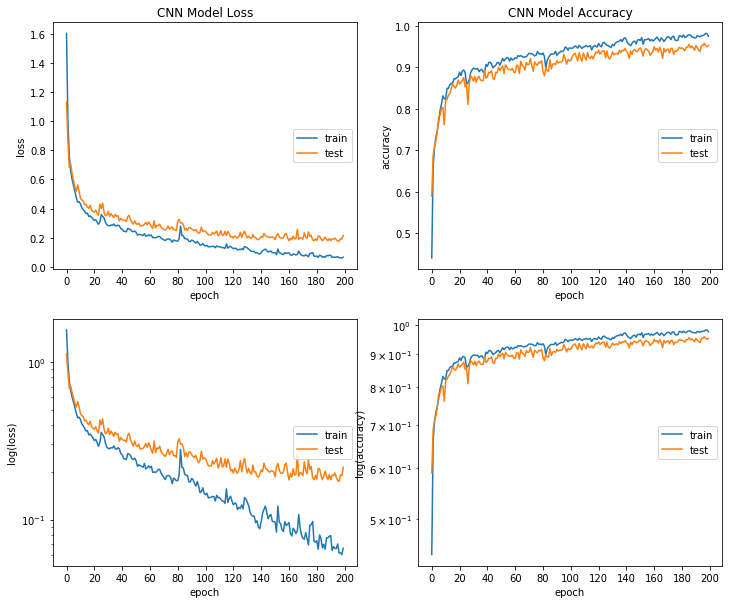

In [66]:
plot_loss_history(CNNmodel0)

In [67]:
cnn0 = CNN_Model(cube_std0_3d.shape[2])
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel0 = cnn0.fit({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0),
                     epochs=100, batch_size=512)

Epoch 1/100
6/6 [==============================] - 1s 118ms/step - loss: 1.7546 - accuracy: 0.4177 - val_loss: 1.2051 - val_accuracy: 0.6146
Epoch 2/100
6/6 [==============================] - 1s 84ms/step - loss: 1.0684 - accuracy: 0.6456 - val_loss: 0.8774 - val_accuracy: 0.6990
Epoch 3/100
6/6 [==============================] - 1s 92ms/step - loss: 0.7924 - accuracy: 0.7008 - val_loss: 0.7366 - val_accuracy: 0.6934
Epoch 4/100
6/6 [==============================] - 1s 97ms/step - loss: 0.6735 - accuracy: 0.7331 - val_loss: 0.6611 - val_accuracy: 0.7032
Epoch 5/100
6/6 [==============================] - 1s 97ms/step - loss: 0.5946 - accuracy: 0.7602 - val_loss: 0.5990 - val_accuracy: 0.7778
Epoch 6/100
6/6 [==============================] - 1s 94ms/step - loss: 0.5552 - accuracy: 0.7686 - val_loss: 0.5594 - val_accuracy: 0.7750
Epoch 7/100
6/6 [==============================] - 1s 102ms/step - loss: 0.5328 - accuracy: 0.7820 - val_loss: 0.5543 - val_accuracy: 0.7201
Epoch 8/100
6/6 [=

6/6 [==============================] - 1s 100ms/step - loss: 0.2319 - accuracy: 0.9082 - val_loss: 0.2844 - val_accuracy: 0.8889
Epoch 60/100
6/6 [==============================] - 1s 98ms/step - loss: 0.2218 - accuracy: 0.9191 - val_loss: 0.2919 - val_accuracy: 0.8931
Epoch 61/100
6/6 [==============================] - 1s 105ms/step - loss: 0.2132 - accuracy: 0.9265 - val_loss: 0.2800 - val_accuracy: 0.8847
Epoch 62/100
6/6 [==============================] - 1s 100ms/step - loss: 0.2093 - accuracy: 0.9198 - val_loss: 0.2613 - val_accuracy: 0.9086
Epoch 63/100
6/6 [==============================] - 1s 97ms/step - loss: 0.2121 - accuracy: 0.9248 - val_loss: 0.2729 - val_accuracy: 0.8917
Epoch 64/100
6/6 [==============================] - 1s 95ms/step - loss: 0.2112 - accuracy: 0.9202 - val_loss: 0.2745 - val_accuracy: 0.9001
Epoch 65/100
6/6 [==============================] - 1s 98ms/step - loss: 0.2024 - accuracy: 0.9248 - val_loss: 0.2762 - val_accuracy: 0.9001
Epoch 66/100
6/6 [=====

In [68]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn0.evaluate({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0)
test_loss, test_acc = cnn0.evaluate({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0)

print(train_acc, test_acc)

23/23 [==============================] - 0s 6ms/step - loss: 0.2191 - accuracy: 0.9255
0.9535865187644958 0.9254571199417114


### Predict pixel classification on veg_00000

In [69]:
cube_standard0_1 = cube_standard0.reshape(cube_standard0.shape[0], cube_standard0.shape[1], 1)
print(cube_standard0_1.shape)
xy0_2d = xy0.reshape((xy0.shape[0] * xy0.shape[1]), xy0.shape[2])
print(xy0_2d.shape)

(2560000, 424, 1)
(2560000, 2)


In [70]:
# classify entire binned cube
import time
start_time = time.time()

probCube0 = cnn0.predict({"spectra":cube_standard0_1, "spatial":xy0_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:07:45


In [71]:
predictCube0 = probCube0.argmax(axis=-1)

In [72]:
predictCube_reshape0 = predictCube0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

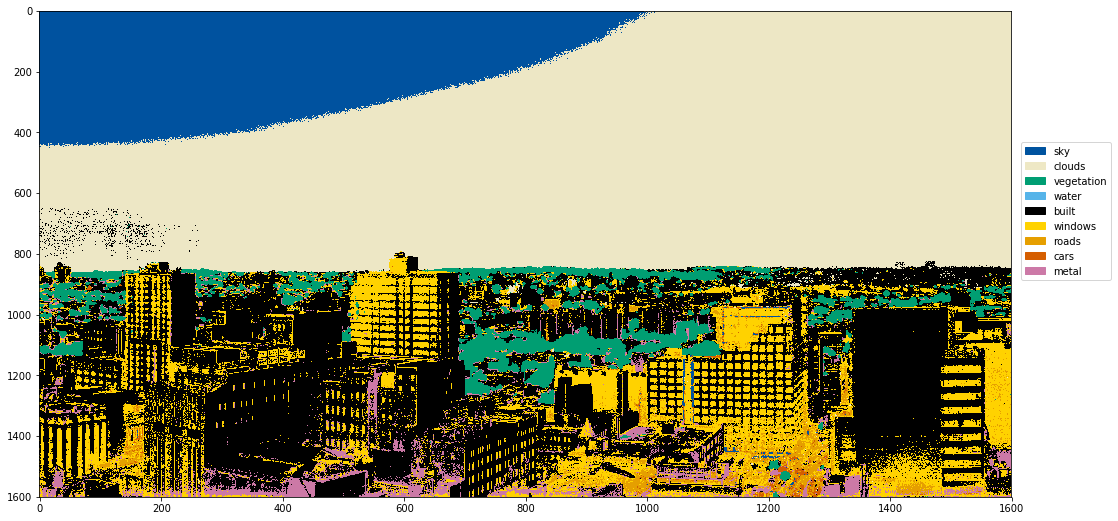

In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_3_000_predict_map.png", 
#bbox_extra_artists=(lgd,), bbox_inches='tight')

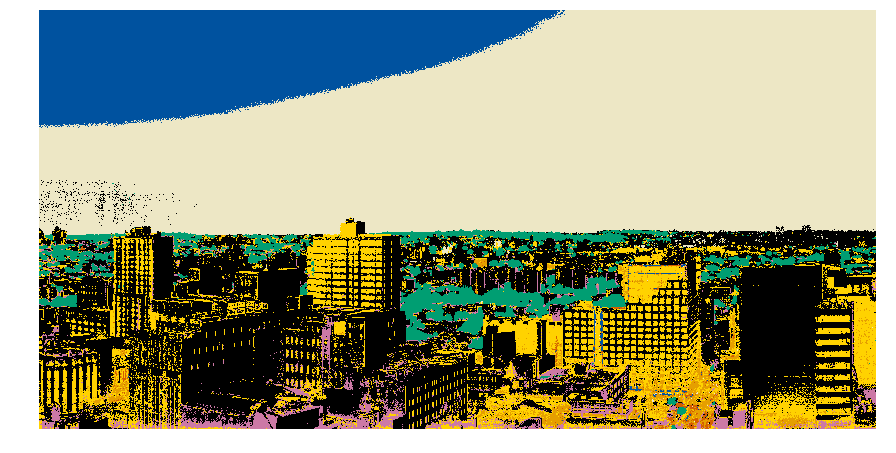

In [74]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_000_binned_{0}_test_000_predict_map.png".format(num_of_bins),
            bbox_inches='tight', dpi=300)

In [75]:
import pickle
pickle.dump(predictCube_reshape0, 
            open("./plots/CNN_Model2_spatial_train_000_binned_{0}_test_000_predict_map.pickle".format(num_of_bins), "wb"))

In [76]:
wtr_coords0=np.array([[0,0]])

### Evaluation Metrics (veg_00000)

In [77]:
labels0_pred_sky = predictCube_reshape0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1]]
labels0_pred_clouds = predictCube_reshape0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:],1]]
labels0_pred_veg = predictCube_reshape0[veg_coords0[veg_test_ind0[:],0], veg_coords0[veg_test_ind0[:],1]]
#labels0_pred_wtr = predictCube_reshape0[wtr_coords0[wtr_test_ind0[:],0], wtr_coords0[wtr_test_ind0[:],1]]
labels0_pred_blt = predictCube_reshape0[blt_coords0[blt_test_ind0[:],0], blt_coords0[blt_test_ind0[:],1]]
labels0_pred_windows = predictCube_reshape0[windows_coords0[windows_test_ind0[:],0], windows_coords0[windows_test_ind0[:],1]]
labels0_pred_rds = predictCube_reshape0[rds_coords0[rds_test_ind0[:],0], rds_coords0[rds_test_ind0[:],1]]
labels0_pred_cars = predictCube_reshape0[cars_coords0[cars_test_ind0[:],0], cars_coords0[cars_test_ind0[:],1]]
labels0_pred_mtl = predictCube_reshape0[mtl_coords0[mtl_test_ind0[:],0], mtl_coords0[mtl_test_ind0[:],1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, #labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, 
                               labels0_pred_cars, labels0_pred_mtl))

In [78]:
labels0_true_sky = np.full(len(sky_test_ind0), 0)
labels0_true_clouds = np.full(len(clouds_test_ind0), 1)
labels0_true_veg = np.full(len(veg_test_ind0), 2)
#labels0_true_wtr = np.full(len(wtr_test_ind0), 3)
labels0_true_blt = np.full(len(blt_test_ind0), 4)
labels0_true_windows = np.full(len(windows_test_ind0), 5)
labels0_true_rds = np.full(len(rds_test_ind0), 6)
labels0_true_cars = np.full(len(cars_test_ind0), 7)
labels0_true_mtl = np.full(len(mtl_test_ind0), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, #labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [79]:
print(labels0_pred.shape)
print(labels0_true.shape)

(711,)
(711,)


In [80]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels0_true, labels0_pred))

target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))

Confusion Matrix
[[ 80   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0]
 [  0   0 119   3   0   0   0   0]
 [  0   0   0 230   6   0   0   4]
 [  0   0   0  16  82   0   0   2]
 [  0   0   0   0   1  11   0   0]
 [  1   1   0   0   0   1   8   0]
 [  0   0   0  16   2   0   0  28]]

Accuracy Score
0.9254571026722925

Classification Report
             precision    recall  f1-score   support

        sky       0.99      1.00      0.99        80
     clouds       0.99      1.00      1.00       100
 vegetation       1.00      0.98      0.99       122
      built       0.87      0.96      0.91       240
    windows       0.90      0.82      0.86       100
      roads       0.92      0.92      0.92        12
       cars       1.00      0.73      0.84        11
      metal       0.82      0.61      0.70        46

avg / total       0.93      0.93      0.92       711



In [81]:
f = open("./metrics/CNN_Model2_spatial_train_000_binned_{0}_test_000_metrics.txt".format(num_of_bins), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels0_true, labels0_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels0_true, labels0_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))
f.close()

---
## CNN trained on North Facing Image

In [82]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

reading and parsing ../../image_files/scan1_slow_roof_VNIR.hdr...
reading ../../image_files/scan1_slow_roof_VNIR.raw...


In [83]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

(872, 1600, 1247)


In [84]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

(1995200, 872)


In [85]:
cube_standard_north = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
print(cube_standard_north.shape)

(1995200, 872)


#### Reading manually classified set for training and testing

In [86]:
sky_coordsn = read_labelled_coordinates("1_sky", "north")
clouds_coordsn = read_labelled_coordinates("2_clouds", "north")
veg_coordsn = read_labelled_coordinates("3_vegetation", "north")
wtr_coordsn = read_labelled_coordinates("4_water", "north")
blt_coordsn = read_labelled_coordinates("5_buildings", "north")
windows_coordsn = read_labelled_coordinates("6_windows", "north")
rds_coordsn = read_labelled_coordinates("7_roads", "north")
cars_coordsn = read_labelled_coordinates("8_cars", "north")
mtl_coordsn = read_labelled_coordinates("9_metal", "north")

1_sky: (300, 2)
2_clouds: (200, 2)
3_vegetation: (700, 2)
4_water: (620, 2)
5_buildings: (1600, 2)
6_windows: (600, 2)
7_roads: (250, 2)
8_cars: (250, 2)
9_metal: (185, 2)


In [87]:
xyn = coords(cube_sub_north.shape[1], cube_sub_north.shape[2])
xyn = xyn/xyn.max()

### Bin Spectra

In [88]:
bin_ind = []

for i in range(0, num_of_bins):
    low_ind = int(i*int(cube_sub_north.shape[0]/num_of_bins))
    upp_ind = int(low_ind + int(cube_sub_north.shape[0]/num_of_bins))
    bin_ind.append([low_ind, upp_ind])
bin_ind[-1][-1] = cube_sub_north.shape[0]

print(len(bin_ind))
print(bin_ind)

424
[[0, 2], [2, 4], [4, 6], [6, 8], [8, 10], [10, 12], [12, 14], [14, 16], [16, 18], [18, 20], [20, 22], [22, 24], [24, 26], [26, 28], [28, 30], [30, 32], [32, 34], [34, 36], [36, 38], [38, 40], [40, 42], [42, 44], [44, 46], [46, 48], [48, 50], [50, 52], [52, 54], [54, 56], [56, 58], [58, 60], [60, 62], [62, 64], [64, 66], [66, 68], [68, 70], [70, 72], [72, 74], [74, 76], [76, 78], [78, 80], [80, 82], [82, 84], [84, 86], [86, 88], [88, 90], [90, 92], [92, 94], [94, 96], [96, 98], [98, 100], [100, 102], [102, 104], [104, 106], [106, 108], [108, 110], [110, 112], [112, 114], [114, 116], [116, 118], [118, 120], [120, 122], [122, 124], [124, 126], [126, 128], [128, 130], [130, 132], [132, 134], [134, 136], [136, 138], [138, 140], [140, 142], [142, 144], [144, 146], [146, 148], [148, 150], [150, 152], [152, 154], [154, 156], [156, 158], [158, 160], [160, 162], [162, 164], [164, 166], [166, 168], [168, 170], [170, 172], [172, 174], [174, 176], [176, 178], [178, 180], [180, 182], [182, 184],

In [89]:
cube_binnedn = np.zeros(shape=(cube_standard_north.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binnedn[:, i] = cube_standard_north[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binnedn.shape)

(1995200, 424)


In [90]:
cube_standard_north = cube_binnedn
print(cube_standard_north.shape)

(1995200, 424)


#### split classified pixels into 80% training and 20% testing sets

In [91]:
trrat = 0.8
sky_train_indn, sky_test_indn = split_train_test_indices(sky_coordsn, 100, trrat, "sky")
clouds_train_indn, clouds_test_indn = split_train_test_indices(clouds_coordsn, 200, trrat, "clouds")
veg_train_indn, veg_test_indn = split_train_test_indices(veg_coordsn, 300, trrat, "veg")
wtr_train_indn, wtr_test_indn = split_train_test_indices(wtr_coordsn, 400, trrat, "wtr")
blt_train_indn, blt_test_indn = split_train_test_indices(blt_coordsn, 500, trrat, "blt")
windows_train_indn, windows_test_indn = split_train_test_indices(windows_coordsn, 600, trrat, "windows")
rds_train_indn, rds_test_indn = split_train_test_indices(rds_coordsn, 700, trrat, "rds")
cars_train_indn, cars_test_indn = split_train_test_indices(cars_coordsn, 800, trrat, "cars")
mtl_train_indn, mtl_test_indn = split_train_test_indices(mtl_coordsn, 900, trrat, "mtl")

sky: 240 60
clouds: 160 40
veg: 560 140
wtr: 496 124
blt: 1280 320
windows: 480 120
rds: 200 50
cars: 200 50
mtl: 148 37


In [92]:
cube_stdn_3d = cube_standard_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], num_of_bins)
print(cube_stdn_3d.shape)
print(xyn.shape)

(1600, 1247, 424)
(1600, 1247, 2)


In [93]:
cube_sky_trainn = cube_stdn_3d[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
cube_sky_testn = cube_stdn_3d[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
sky_xy_trainn = xyn[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
sky_xy_testn = xyn[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
print("sky ", cube_sky_trainn.shape, cube_sky_testn.shape)

cube_clouds_trainn = cube_stdn_3d[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
cube_clouds_testn = cube_stdn_3d[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
clouds_xy_trainn = xyn[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
clouds_xy_testn = xyn[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
print("clouds ", cube_clouds_trainn.shape, cube_clouds_testn.shape)

cube_veg_trainn = cube_stdn_3d[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
cube_veg_testn = cube_stdn_3d[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
veg_xy_trainn = xyn[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
veg_xy_testn = xyn[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
print("vegetation ", cube_veg_trainn.shape, cube_veg_testn.shape)

cube_wtr_trainn = cube_stdn_3d[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
cube_wtr_testn = cube_stdn_3d[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
wtr_xy_trainn = xyn[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
wtr_xy_testn = xyn[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
print("water ", cube_wtr_trainn.shape, cube_wtr_testn.shape)

cube_blt_trainn = cube_stdn_3d[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
cube_blt_testn = cube_stdn_3d[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
blt_xy_trainn = xyn[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
blt_xy_testn = xyn[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
print("built ", cube_blt_trainn.shape, cube_blt_testn.shape)

cube_windows_trainn = cube_stdn_3d[windows_coordsn[windows_train_indn[:],0], windows_coordsn[windows_train_indn[:],1],:]
cube_windows_testn = cube_stdn_3d[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
windows_xy_trainn = xyn[windows_coordsn[windows_train_indn[:], 0], windows_coordsn[windows_train_indn[:], 1], :]
windows_xy_testn = xyn[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
print("windows ", cube_windows_trainn.shape, cube_windows_testn.shape)

cube_rds_trainn = cube_stdn_3d[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
cube_rds_testn = cube_stdn_3d[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
rds_xy_trainn = xyn[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
rds_xy_testn = xyn[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
print("roads ", cube_rds_trainn.shape, cube_rds_testn.shape)

cube_cars_trainn = cube_stdn_3d[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cube_cars_testn = cube_stdn_3d[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
cars_xy_trainn = xyn[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cars_xy_testn = xyn[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
print("cars ", cube_cars_trainn.shape, cube_cars_testn.shape)

cube_mtl_trainn = cube_stdn_3d[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
cube_mtl_testn = cube_stdn_3d[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
mtl_xy_trainn = xyn[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
mtl_xy_testn = xyn[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
print("metal ", cube_mtl_trainn.shape, cube_mtl_testn.shape)

sky  (240, 424) (60, 424)
clouds  (160, 424) (40, 424)
vegetation  (560, 424) (140, 424)
water  (496, 424) (124, 424)
built  (1280, 424) (320, 424)
windows  (480, 424) (120, 424)
roads  (200, 424) (50, 424)
cars  (200, 424) (50, 424)
metal  (148, 424) (37, 424)


In [94]:
# concatenate training and testing sets and create index arrays

cube_trainn = np.concatenate((cube_sky_trainn, cube_clouds_trainn, cube_veg_trainn, cube_wtr_trainn, cube_blt_trainn, 
                            cube_windows_trainn, cube_rds_trainn, cube_cars_trainn, cube_mtl_trainn), axis=0)
cube_train_labelsn = [0]*cube_sky_trainn.shape[0] + [1]*cube_clouds_trainn.shape[0] \
                    + [2]*cube_veg_trainn.shape[0] + [3]*cube_wtr_trainn.shape[0] + [4]*cube_blt_trainn.shape[0] \
                    + [5]*cube_windows_trainn.shape[0] + [6]*cube_rds_trainn.shape[0] \
                    + [7]*cube_cars_trainn.shape[0] + [8]*cube_mtl_trainn.shape[0]
xy_trainn = np.concatenate((sky_xy_trainn, clouds_xy_trainn, veg_xy_trainn, wtr_xy_trainn, blt_xy_trainn,
                             windows_xy_trainn, rds_xy_trainn, cars_xy_trainn, mtl_xy_trainn), axis=0)

cube_testn = np.concatenate((cube_sky_testn, cube_clouds_testn, cube_veg_testn, cube_wtr_testn, cube_blt_testn, 
                            cube_windows_testn, cube_rds_testn, cube_cars_testn, cube_mtl_testn), axis=0)
cube_test_labelsn = [0]*cube_sky_testn.shape[0] + [1]*cube_clouds_testn.shape[0] \
                    + [2]*cube_veg_testn.shape[0] + [3]*cube_wtr_testn.shape[0] + [4]*cube_blt_testn.shape[0] \
                    + [5]*cube_windows_testn.shape[0] + [6]*cube_rds_testn.shape[0] \
                    + [7]*cube_cars_testn.shape[0] + [8]*cube_mtl_testn.shape[0]
xy_testn = np.concatenate((sky_xy_testn, clouds_xy_testn, veg_xy_testn, wtr_xy_testn, blt_xy_testn, 
                             windows_xy_testn, rds_xy_testn, cars_xy_testn, mtl_xy_testn), axis=0)

In [95]:
cube_train_labelsn = np.array(cube_train_labelsn)
cube_test_labelsn = np.array(cube_test_labelsn)

print(cube_trainn.shape, cube_train_labelsn.shape, xy_trainn.shape)
print(cube_testn.shape, cube_test_labelsn.shape, xy_testn.shape)

(3764, 424) (3764,) (3764, 2)
(941, 424) (941,) (941, 2)


#### Train CNN

In [96]:
cnnn = CNN_Model(cube_stdn_3d.shape[2])
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [97]:
#keras.utils.plot_model(cnnn, show_shapes=True)
#cnnn.summary()

cube_trainn2 = cube_trainn.reshape(cube_trainn.shape[0], cube_trainn.shape[1], 1)
cube_testn2 = cube_testn.reshape(cube_testn.shape[0], cube_testn.shape[1], 1)

In [98]:
CNNmodeln = cnnn.fit({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn),
                     epochs=200, batch_size=512)

Epoch 1/200
8/8 [==============================] - 1s 125ms/step - loss: 1.7114 - accuracy: 0.4126 - val_loss: 1.3462 - val_accuracy: 0.5845
Epoch 2/200
8/8 [==============================] - 1s 105ms/step - loss: 1.2404 - accuracy: 0.5677 - val_loss: 1.1525 - val_accuracy: 0.6015
Epoch 3/200
8/8 [==============================] - 1s 94ms/step - loss: 1.0564 - accuracy: 0.6214 - val_loss: 0.9667 - val_accuracy: 0.6514
Epoch 4/200
8/8 [==============================] - 1s 110ms/step - loss: 0.9156 - accuracy: 0.6857 - val_loss: 0.8493 - val_accuracy: 0.7322
Epoch 5/200
8/8 [==============================] - 1s 105ms/step - loss: 0.8100 - accuracy: 0.7210 - val_loss: 0.7977 - val_accuracy: 0.7439
Epoch 6/200
8/8 [==============================] - 1s 100ms/step - loss: 0.7604 - accuracy: 0.7402 - val_loss: 0.7037 - val_accuracy: 0.7492
Epoch 7/200
8/8 [==============================] - 1s 104ms/step - loss: 0.7324 - accuracy: 0.7508 - val_loss: 0.7084 - val_accuracy: 0.7609
Epoch 8/200
8/

Epoch 59/200
8/8 [==============================] - 1s 104ms/step - loss: 0.2314 - accuracy: 0.9283 - val_loss: 0.3281 - val_accuracy: 0.9012
Epoch 60/200
8/8 [==============================] - 1s 106ms/step - loss: 0.2404 - accuracy: 0.9184 - val_loss: 0.3141 - val_accuracy: 0.9065
Epoch 61/200
8/8 [==============================] - 1s 108ms/step - loss: 0.2422 - accuracy: 0.9238 - val_loss: 0.3356 - val_accuracy: 0.9012
Epoch 62/200
8/8 [==============================] - 1s 102ms/step - loss: 0.2310 - accuracy: 0.9288 - val_loss: 0.3309 - val_accuracy: 0.9001
Epoch 63/200
8/8 [==============================] - 1s 96ms/step - loss: 0.2348 - accuracy: 0.9251 - val_loss: 0.3367 - val_accuracy: 0.9086
Epoch 64/200
8/8 [==============================] - 1s 107ms/step - loss: 0.2411 - accuracy: 0.9179 - val_loss: 0.3237 - val_accuracy: 0.9012
Epoch 65/200
8/8 [==============================] - 1s 107ms/step - loss: 0.2429 - accuracy: 0.9190 - val_loss: 0.3480 - val_accuracy: 0.8810
Epoch 6

Epoch 117/200
8/8 [==============================] - 1s 97ms/step - loss: 0.1547 - accuracy: 0.9495 - val_loss: 0.3211 - val_accuracy: 0.9129
Epoch 118/200
8/8 [==============================] - 1s 92ms/step - loss: 0.1357 - accuracy: 0.9570 - val_loss: 0.3123 - val_accuracy: 0.9139
Epoch 119/200
8/8 [==============================] - 1s 91ms/step - loss: 0.1442 - accuracy: 0.9524 - val_loss: 0.3147 - val_accuracy: 0.9139
Epoch 120/200
8/8 [==============================] - 1s 104ms/step - loss: 0.1350 - accuracy: 0.9562 - val_loss: 0.3211 - val_accuracy: 0.9129
Epoch 121/200
8/8 [==============================] - 1s 96ms/step - loss: 0.1437 - accuracy: 0.9532 - val_loss: 0.3050 - val_accuracy: 0.9107
Epoch 122/200
8/8 [==============================] - 1s 99ms/step - loss: 0.1428 - accuracy: 0.9522 - val_loss: 0.3155 - val_accuracy: 0.9129
Epoch 123/200
8/8 [==============================] - 1s 96ms/step - loss: 0.1383 - accuracy: 0.9522 - val_loss: 0.2954 - val_accuracy: 0.9182
Epoch

8/8 [==============================] - 1s 98ms/step - loss: 0.0766 - accuracy: 0.9769 - val_loss: 0.3362 - val_accuracy: 0.9192
Epoch 175/200
8/8 [==============================] - 1s 94ms/step - loss: 0.0847 - accuracy: 0.9753 - val_loss: 0.3256 - val_accuracy: 0.9150
Epoch 176/200
8/8 [==============================] - 1s 105ms/step - loss: 0.0751 - accuracy: 0.9777 - val_loss: 0.3544 - val_accuracy: 0.9097
Epoch 177/200
8/8 [==============================] - 1s 101ms/step - loss: 0.0931 - accuracy: 0.9687 - val_loss: 0.3678 - val_accuracy: 0.9139
Epoch 178/200
8/8 [==============================] - 1s 100ms/step - loss: 0.0925 - accuracy: 0.9679 - val_loss: 0.3584 - val_accuracy: 0.9171
Epoch 179/200
8/8 [==============================] - 1s 95ms/step - loss: 0.0918 - accuracy: 0.9692 - val_loss: 0.3797 - val_accuracy: 0.9054
Epoch 180/200
8/8 [==============================] - 1s 93ms/step - loss: 0.0840 - accuracy: 0.9716 - val_loss: 0.3364 - val_accuracy: 0.9171
Epoch 181/200
8/8

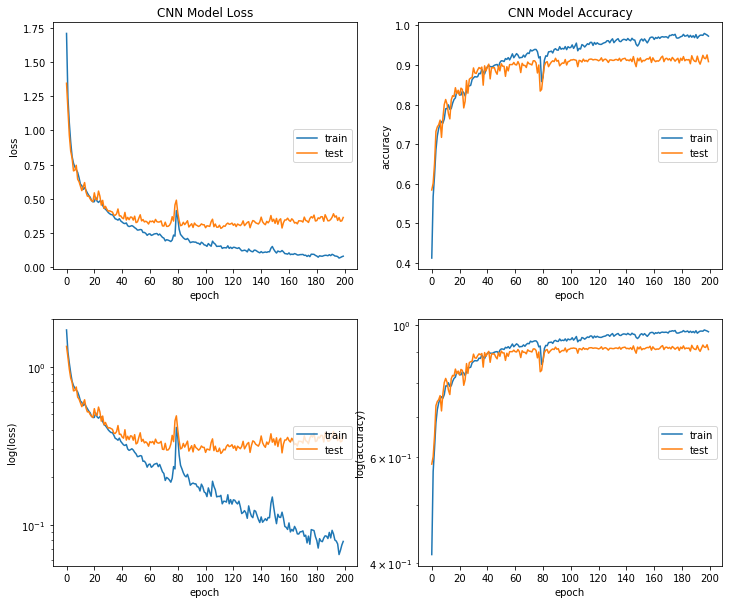

In [99]:
plot_loss_history(CNNmodeln)

In [100]:
cnnn = CNN_Model(cube_stdn_3d.shape[2])
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodeln = cnnn.fit({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn),
                     epochs=70, batch_size=512)

Epoch 1/70
8/8 [==============================] - 1s 127ms/step - loss: 2.0205 - accuracy: 0.3148 - val_loss: 1.6640 - val_accuracy: 0.3549
Epoch 2/70
8/8 [==============================] - 1s 99ms/step - loss: 1.5138 - accuracy: 0.4469 - val_loss: 1.3751 - val_accuracy: 0.5143
Epoch 3/70
8/8 [==============================] - 1s 96ms/step - loss: 1.3251 - accuracy: 0.5393 - val_loss: 1.2414 - val_accuracy: 0.5430
Epoch 4/70
8/8 [==============================] - 1s 98ms/step - loss: 1.2013 - accuracy: 0.5842 - val_loss: 1.1815 - val_accuracy: 0.6089
Epoch 5/70
8/8 [==============================] - 1s 87ms/step - loss: 1.0939 - accuracy: 0.5938 - val_loss: 1.0509 - val_accuracy: 0.5972
Epoch 6/70
8/8 [==============================] - 1s 91ms/step - loss: 1.0034 - accuracy: 0.6243 - val_loss: 0.9468 - val_accuracy: 0.6801
Epoch 7/70
8/8 [==============================] - 1s 99ms/step - loss: 0.9212 - accuracy: 0.6761 - val_loss: 0.8526 - val_accuracy: 0.7269
Epoch 8/70
8/8 [==========

8/8 [==============================] - 1s 88ms/step - loss: 0.3505 - accuracy: 0.8852 - val_loss: 0.3579 - val_accuracy: 0.9054
Epoch 60/70
8/8 [==============================] - 1s 98ms/step - loss: 0.3377 - accuracy: 0.8940 - val_loss: 0.3628 - val_accuracy: 0.9065
Epoch 61/70
8/8 [==============================] - 1s 93ms/step - loss: 0.3530 - accuracy: 0.8804 - val_loss: 0.3574 - val_accuracy: 0.9075
Epoch 62/70
8/8 [==============================] - 1s 101ms/step - loss: 0.3342 - accuracy: 0.8884 - val_loss: 0.3484 - val_accuracy: 0.9033
Epoch 63/70
8/8 [==============================] - 1s 105ms/step - loss: 0.3436 - accuracy: 0.8850 - val_loss: 0.3516 - val_accuracy: 0.9118
Epoch 64/70
8/8 [==============================] - 1s 107ms/step - loss: 0.3434 - accuracy: 0.8879 - val_loss: 0.3395 - val_accuracy: 0.9022
Epoch 65/70
8/8 [==============================] - 1s 103ms/step - loss: 0.3277 - accuracy: 0.8913 - val_loss: 0.3506 - val_accuracy: 0.9086
Epoch 66/70
8/8 [===========

In [101]:
# model accuracy on training and testing sets

train_loss, train_acc = cnnn.evaluate({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn)
test_loss, test_acc = cnnn.evaluate({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn)

print(train_acc, test_acc)

30/30 [==============================] - 0s 7ms/step - loss: 0.3298 - accuracy: 0.9075
0.9248140454292297 0.9075451493263245


### Predict pixel classification on north facing image

In [102]:
cube_standardn_1 = cube_standard_north.reshape(cube_standard_north.shape[0], cube_standard_north.shape[1], 1)
print(cube_standardn_1.shape)
xyn_2d = xyn.reshape((xyn.shape[0] * xyn.shape[1]), xyn.shape[2])
print(xyn_2d.shape)

(1995200, 424, 1)
(1995200, 2)


In [103]:
# classify entire binned cube
import time
start_time = time.time()

probCuben = cnnn.predict({"spectra":cube_standardn_1, "spatial":xyn_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:06:01


In [104]:
predictCuben = probCuben.argmax(axis=-1)

In [105]:
predictCube_reshapen = predictCuben.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

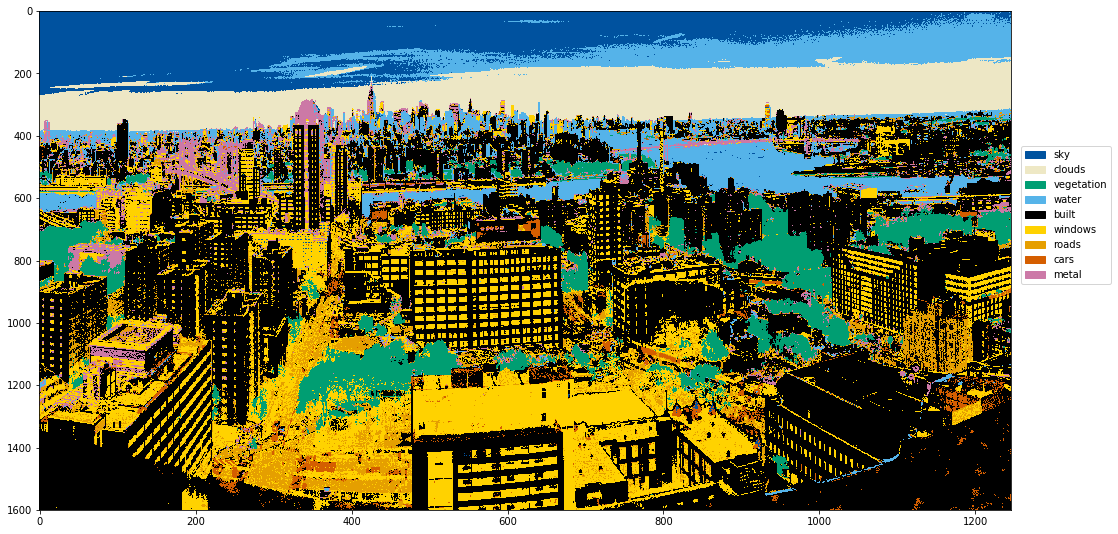

In [106]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_5_north_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

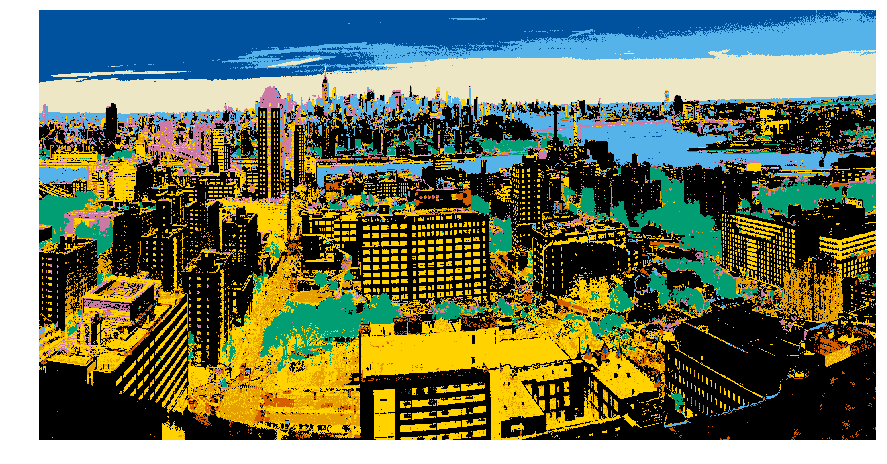

In [107]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.4)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_north_binned_{0}_test_north_predict_map.png".format(num_of_bins),
            bbox_inches='tight', dpi=300)

In [108]:
import pickle
pickle.dump(predictCube_reshapen,
            open("./plots/CNN_Model2_spatial_train_north_binned_{0}_test_north_predict_map.pickle".format(num_of_bins),
                 "wb"))

### Evaluation Metrics (north facing)

In [109]:
labelsn_pred_sky = predictCube_reshapen[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1]]
labelsn_pred_clouds = predictCube_reshapen[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:],1]]
labelsn_pred_veg = predictCube_reshapen[veg_coordsn[veg_test_indn[:],0], veg_coordsn[veg_test_indn[:],1]]
labelsn_pred_wtr = predictCube_reshapen[wtr_coordsn[wtr_test_indn[:],0], wtr_coordsn[wtr_test_indn[:],1]]
labelsn_pred_blt = predictCube_reshapen[blt_coordsn[blt_test_indn[:],0], blt_coordsn[blt_test_indn[:],1]]
labelsn_pred_windows = predictCube_reshapen[windows_coordsn[windows_test_indn[:],0], windows_coordsn[windows_test_indn[:],1]]
labelsn_pred_rds = predictCube_reshapen[rds_coordsn[rds_test_indn[:],0], rds_coordsn[rds_test_indn[:],1]]
labelsn_pred_cars = predictCube_reshapen[cars_coordsn[cars_test_indn[:],0], cars_coordsn[cars_test_indn[:],1]]
labelsn_pred_mtl = predictCube_reshapen[mtl_coordsn[mtl_test_indn[:],0], mtl_coordsn[mtl_test_indn[:],1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [110]:
labelsn_true_sky = np.full(len(sky_test_indn), 0)
labelsn_true_clouds = np.full(len(clouds_test_indn), 1)
labelsn_true_veg = np.full(len(veg_test_indn), 2)
labelsn_true_wtr = np.full(len(wtr_test_indn), 3)
labelsn_true_blt = np.full(len(blt_test_indn), 4)
labelsn_true_windows = np.full(len(windows_test_indn), 5)
labelsn_true_rds = np.full(len(rds_test_indn), 6)
labelsn_true_cars = np.full(len(cars_test_indn), 7)
labelsn_true_mtl = np.full(len(mtl_test_indn), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [111]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

(941,)
(941,)


In [112]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labelsn_true, labelsn_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0  40   0   0   0   0   0   0   0]
 [  0   0 139   1   0   0   0   0   0]
 [  1   0   0 118   0   1   0   0   4]
 [  0   0   0   0 310   6   1   1   2]
 [  0   0   0   0   4 108   4   2   2]
 [  0   0   1   0   7  10  28   0   4]
 [  0   0   0   0   8   9   0  32   1]
 [  0   0   0   2   7   9   0   0  19]]

Accuracy Score
0.9075451647183846

Classification Report
             precision    recall  f1-score   support

        sky       0.98      1.00      0.99        60
     clouds       1.00      1.00      1.00        40
 vegetation       0.99      0.99      0.99       140
      water       0.98      0.95      0.96       124
      built       0.92      0.97      0.95       320
    windows       0.76      0.90      0.82       120
      roads       0.85      0.56      0.67        50
       cars       0.91      0.64      0.75        50
      metal       0.59      0.51      0.55        37

avg / total       0.91      0.91      0.9

In [113]:
f = open("./metrics/CNN_Model2_spatial_train_north_binned_{0}_test_north_metrics.txt".format(num_of_bins), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labelsn_true, labelsn_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labelsn_true, labelsn_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))
f.close()